In [ ]:
# !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [20]:
import os
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import isodate
from googleapiclient.discovery import build
from api_keys import api_key
import scipy.stats as st

In [4]:
# Reading in the datafile
cleaned_us_data_df = pd.read_csv('output/cleaned_us_data.csv')

In [5]:
# Obtaining the unique video_ids to use in the API call
unique_video_id_list = cleaned_us_data_df.drop_duplicates(subset=['video_id'])
unique_video_id_list = unique_video_id_list['video_id']

# Saving it to a dataframe so I can put the video_ids into a list format
unique_video_id_list_df = pd.DataFrame(unique_video_id_list)

# Creating a list of the video_id's to use in the API call
unique_video_id_list = unique_video_id_list_df['video_id'].tolist()

In [6]:
# Running the youtube API and pulling back the video_id and duration
API_KEY = api_key
channel_id = "UC8JOgFXp-I3YV6dsKqqQdUw"
youtube = build('youtube', 'v3', developerKey=API_KEY)

stats_list=[]
    
for i in range(0, len(unique_video_id_list), 50):
    request = youtube.videos().list(
    part="snippet,contentDetails,statistics",
    id=unique_video_id_list[i:i+50]
    )
    
    try:
        data = request.execute()
 
        for video in data['items']:
            video_id = video['id']
            duration = (video['contentDetails']['duration'])
            stats_dictionary = dict(video_id=video_id, duration=''.join(duration))
            stats_list.append(stats_dictionary)
    
    except:
        pass

In [7]:
# Saving output to dataframe and a csv file
video_length_df = pd.DataFrame(stats_list)
video_length_csv = video_length_df.to_csv('output/video_length.csv', index=False, header=True)

In [8]:
# Merging the duration data into the main data file
duration_data_df = pd.merge(cleaned_us_data_df, video_length_df, on='video_id',how='left')

In [9]:
# Dropping rows that do not have a youtube duration
duration_data_df = duration_data_df.dropna(how='any', subset=['duration'])

In [11]:
# Converting youtube video duration into seconds
duration_seconds_list = []

for video in duration_data_df['duration']:
    dur = isodate.parse_duration(video)
    dur_seconds = dur.total_seconds()
    duration_seconds_list.append(dur_seconds)

# Saving it to a column in the dataframe
duration_data_df['duration_seconds'] = duration_seconds_list

In [14]:
# Filtering rows so we only get the lastest trending date row for each video

# Changing trending_date to date format it can be sorted by date
unique_video_id_duration = pd.to_datetime(duration_data_df['trending_date'], format='%y.%d.%m')

# Sorting the dataframe by trending_date in ascending order
unique_video_id_duration = duration_data_df.sort_values(by='trending_date', ascending=True)

# Taking the last row for each video_id
unique_video_id_duration = duration_data_df.groupby('video_id').last()
unique_video_id_duration.reset_index(inplace = True)

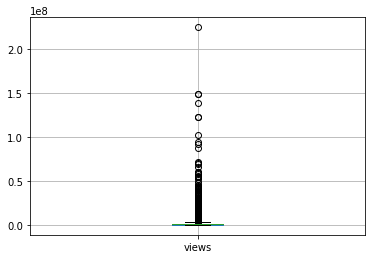

In [16]:
# Boxplot of views
unique_video_id_duration.boxplot(column='views')

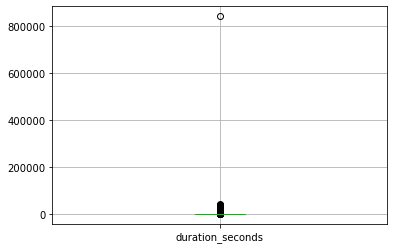

In [17]:
# Boxplot of video duration
unique_video_id_duration.boxplot(column='duration_seconds')

The correlation between both factors is -0.01


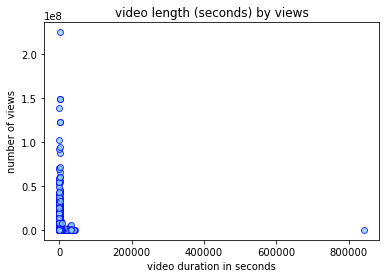

<Figure size 7200x7200 with 0 Axes>

In [22]:
x_axis = unique_video_id_duration['duration_seconds']
data = unique_video_id_duration['views']
plt.scatter(x_axis, data, marker="o", facecolors="lightskyblue", edgecolors="blue", alpha=0.75)
plt.ylim()
plt.xlim()
plt.xlabel("video duration in seconds")
plt.ylabel("number of views")
plt.title("video length (seconds) by views")
plt.figure(figsize=(100,100));
correlation = st.pearsonr(x_axis, data)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.01


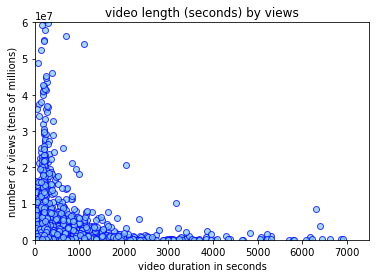

<Figure size 7200x7200 with 0 Axes>

In [21]:
x_axis = unique_video_id_duration['duration_seconds']
data = unique_video_id_duration['views']
plt.scatter(x_axis, data, marker="o", facecolors="lightskyblue", edgecolors="blue", alpha=0.75)
plt.ylim(0, 60000000)
plt.xlim(0, 7500)
plt.xlabel("video duration in seconds")
plt.ylabel("number of views (tens of millions)")
plt.title("video length (seconds) by views")
plt.figure(figsize=(100,100));
correlation = st.pearsonr(x_axis, data)
print(f"The correlation between both factors is {round(correlation[0],2)}")